# Advanced HPP Model

## Evaluating the performance of a hybrid power plant using HyDesign

HyDesign is an open-source tool for design and optimization of utility scale wind-solar-storage based hybrid power plants.

In this notebook we will evaluate a hybrid power plant design in a specific location.

A hybrid power plant design consists on selecting the following parameters:

**Wind Turbine design:**

1. Clearance [m] (`clearance`): Height from the ground to rotor tip at lowest posstion. This parameter controls the wind turbine hub height given a rotor radius: `clearance =  HH - R`. 
2. Specific power of the wind turbine [MW/m2] (`sp`): Defined as `sp = p_rated / ( pi * R^2 )`, it controls the turbine rotor size for a given rated power. Turbines with lower specific power produce more power at lower wind speeds, but are more expensive.
3. Rated power of the wind turbine [MW] (`p_rated`)

**Wind Plant design:**

4. Number of wind turbines in the wind plant [-] (`Nwt`)
5. Wind power installation density [MW/km2] (`wind_MW_per_km2`): This parameter controls how closely spaced are the turbines, which in turns affect how much wake losses are present.

**PV Plant design:**

6. Solar plant power capacity [MW] (`solar_MW`)
7. Surface tilt [deg] (`surface_tilt`)
8. Surface azimuth [deg] (`surface_azimuth`)
9. DC-AC ratio [-] (`solar_DCAC`): This parameter controls how much over-planting of PV (in DC power) is connected to the inverters. It is common practice in PV design to have `solar_DCAC = 1.5`. 

**Battery Storage design:**

10. Battery power [MW] (`b_P`)
11. Battery energy capacity in hours [MWh] (`b_E_h `): Battery storage capacity in hours of full battery power (`b_E = b_E_h * b_P `). 
12. Cost of battery power fluctuations in peak price ratio [-] (`cost_of_batt_degr`): This parameter controls how much penalty is given to do ramps in battery power in the HPP operation.


##
**Imports**

Install hydesign if needed.
Import basic libraries. 
Import HPP model assembly class.
Import the examples file path.

In [2]:
# Install hydesign if needed
import importlib
if not importlib.util.find_spec("hydesign"):
    !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/hydesign.git    

In [3]:
import os
import time
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from hydesign.assembly.hpp_assembly import hpp_model
from hydesign.examples import examples_filepath

##
**Specifying the site**

Hydesign, provides example data from several sites in India and Europe. 

The site coordinates (longitude, latitude, and altitude) are given in `examples_sites.csv`.

In [4]:
examples_sites = pd.read_csv(f'{examples_filepath}examples_sites.csv', index_col=0, sep=';')
examples_sites
print(type(examples_sites))
display(examples_sites)

<class 'pandas.core.frame.DataFrame'>


,case,name,longitude,latitude,altitude,input_ts_fn,sim_pars_fn,price_fn,price_col,H2_demand_col,input_HA_ts_fn,price_up_ts,price_dwn_ts
0,India,Indian_site_good_wind,77.500226,8.334294,679.803454,India/GWA2/input_ts_Indian_site_good_wind.csv,India/hpp_pars.yml,India/Indian_elec_price_t.csv,Price,India/H2_demand.csv,NaN,NaN,NaN
1,India,Indian_site_good_solar,68.542204,23.542099,29.883557,India/GWA2/input_ts_Indian_site_good_solar.csv,India/hpp_pars.yml,India/Indian_elec_price_t.csv,Price,India/H2_demand.csv,NaN,NaN,NaN
2,India,Indian_site_bad_solar_bad_wind,77.916878,17.292316,627.424643,India/GWA2/input_ts_Indian_site_bad_solar_bad_...,India/hpp_pars.yml,India/Indian_elec_price_t.csv,Price,India/H2_demand.csv,NaN,NaN,NaN
3,Europe,France_good_solar,4.229736,44.422011,204.000000,Europe/GWA2/input_ts_France_good_solar.csv,Europe/hpp_pars.yml,Europe/2030-EL_PRICE.csv,FR_R,Europe/H2_demand.csv,NaN,NaN,NaN
4,Europe,France_good_wind,-0.864258,48.744116,302.000000,Europe/GWA2/input_ts_France_good_wind.csv,Europe/hpp_pars.yml,Europe/2030-EL_PRICE.csv,FR_R,Europe/H2_demand.csv,NaN,NaN,NaN
5,Europe,France_bad_solar_n_wind,2.167969,47.428087,140.000000,Europe/GWA2/input_ts_France_bad_solar_n_wind.csv,Europe/hpp_pars.yml,Europe/2030-EL_PRICE.csv,FR_R,Europe/H2_demand.csv,NaN,NaN,NaN
6,Europe,Germany_bad_solar_n_wind,10.766602,49.310798,442.000000,Europe/GWA2/input_ts_Germany_bad_solar_n_wind.csv,Europe/hpp_pars.yml,Europe/2030-EL_PRICE.csv,DE_ME,Europe/H2_demand.csv,NaN,NaN,NaN
7,Europe,Germany_good_wind,7.873535,53.287111,5.000000,Europe/GWA2/input_ts_Germany_good_wind.csv,Europe/hpp_pars.yml,Europe/2030-EL_PRICE.csv,DE_NW,Europe/H2_demand.csv,NaN,NaN,NaN
8,Europe,Denmark_good_solar,11.813965,55.397760,42.000000,Europe/GWA2/input_ts_Denmark_good_solar.csv,Europe/hpp_pars.yml,Europe/2030-EL_PRICE.csv,DK_E,Europe/H2_demand.csv,NaN,NaN,NaN
9,Europe,Denmark_good_wind,8.594398,56.227322,85.000000,Europe/GWA2/input_ts_Denmark_good_wind.csv,Europe/hpp_pars.yml,Europe/2030-EL_PRICE.csv,DK_W,Europe/H2_demand.csv,NaN,NaN,NaN


In [28]:
name = 'Marijampole'
ex_site = examples_sites.loc[examples_sites.name == name]

longitude = ex_site['longitude'].values[0]
latitude = ex_site['latitude'].values[0]
altitude = ex_site['altitude'].values[0]

input_ts_fn = examples_filepath+ex_site['input_ts_fn'].values[0]
sim_pars_fn = examples_filepath+ex_site['sim_pars_fn'].values[0]
print(type(sim_pars_fn))


<class 'str'>


## 
**Initializing the HPP model**

Initialize the HPP model (hpp_model class) with the coordinates and the necessary input files.

In [6]:
hpp = hpp_model(
        latitude=latitude,
        longitude=longitude,
        altitude=altitude,
        num_batteries = 5,
        work_dir = './',
        sim_pars_fn = sim_pars_fn,
        input_ts_fn = input_ts_fn,
)
print(input_ts_fn)


Fixed parameters on the site
-------------------------------
longitude = 23.348694
latitude = 54.556137
altitude = 73.0
/usr/local/Caskroom/miniconda/base/envs/hydesign/lib/python3.11/site-packages/hydesign/examples/Europe/GWA2/input_ts_Marijampole_LT.csv


##
### Evaluating the HPP model

In [7]:
start = time.time()

clearance = 10
sp = 350
p_rated = 5
Nwt = 40
wind_MW_per_km2 = 7
solar_MW = 200
surface_tilt = 50
surface_azimuth = 180
solar_DCAC = 1.5
b_P = 50
b_E_h  = 3
cost_of_batt_degr = 10

x = [clearance, sp, p_rated, Nwt, wind_MW_per_km2, \
solar_MW, surface_tilt, surface_azimuth, solar_DCAC, \
b_P, b_E_h , cost_of_batt_degr]

outs = hpp.evaluate(*x)

hpp.print_design(x, outs)

end = time.time()
print(f'exec. time [min]:', (end - start)/60 )


Design:
---------------
clearance [m]: 10.000
sp [W/m2]: 350.000
p_rated [MW]: 5.000
Nwt: 40.000
wind_MW_per_km2 [MW/km2]: 7.000
solar_MW [MW]: 200.000
surface_tilt [deg]: 50.000
surface_azimuth [deg]: 180.000
DC_AC_ratio: 1.500
b_P [MW]: 50.000
b_E_h [h]: 3.000
cost_of_battery_P_fluct_in_peak_price_ratio: 10.000


NPV_over_CAPEX: 0.265
NPV [MEuro]: 77.949
IRR: 0.082
LCOE [Euro/MWh]: 47.350
Revenues [MEuro]: 21.555
CAPEX [MEuro]: 294.451
OPEX [MEuro]: 4.400
Wind CAPEX [MEuro]: 152.861
Wind OPEX [MEuro]: 3.050
PV CAPEX [MEuro]: 67.000
PV OPEX [MEuro]: 1.350
Batt CAPEX [MEuro]: 15.037
Batt OPEX [MEuro]: 0.000
Shared CAPEX [MEuro]: 59.553
Shared OPEX [MEuro]: 0.000
penalty lifetime [MEuro]: 0.000
AEP [GWh]: 560.255
GUF: 0.213
grid [MW]: 300.000
wind [MW]: 200.000
solar [MW]: 200.000
Battery Energy [MWh]: 150.000
Battery Power [MW]: 50.000
Total curtailment [GWh]: 27.504
Total curtailment with deg [GWh]: 8.534
Awpp [km2]: 28.571
Apvp [km2]: 2.452
Plant area [km2]: 28.571
Rotor diam [m]: 1

In [8]:
print(outs)

[2.64727615e-01 7.79493064e+01 8.22093877e-02 4.73501436e+01
 2.15548020e+01 2.94450983e+02 4.39967096e+00 1.52860801e+02
 3.04967096e+00 6.70000000e+01 1.35000000e+00 1.50367532e+01
 0.00000000e+00 5.95534286e+01 0.00000000e+00 0.00000000e+00
 5.60254731e+02 2.13186732e-01 3.00000000e+02 2.00000000e+02
 2.00000000e+02 1.50000000e+02 5.00000000e+01 2.75041823e+01
 8.53357111e+00 2.85714286e+01 2.45200000e+00 2.85714286e+01
 1.34867106e+02 7.74335531e+01 2.00000000e+00 3.13382479e+01
 1.95951069e-01]


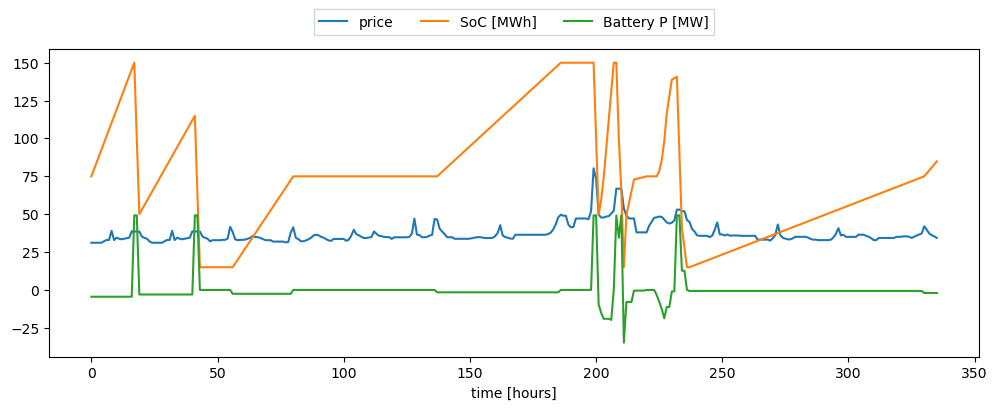

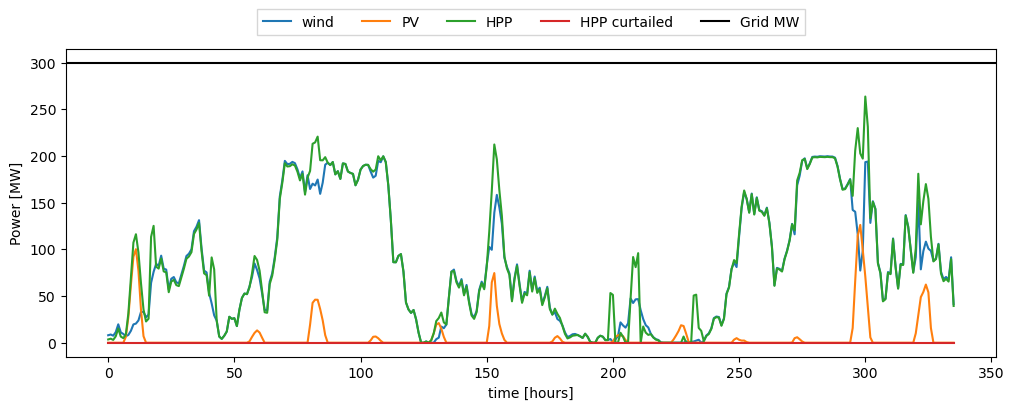

In [9]:
b_E_SOC_t = hpp.prob.get_val('ems.b_E_SOC_t')
b_t = hpp.prob.get_val('ems.b_t')
price_t = hpp.prob.get_val('ems.price_t')

wind_t = hpp.prob.get_val('ems.wind_t')
solar_t = hpp.prob.get_val('ems.solar_t')
hpp_t = hpp.prob.get_val('ems.hpp_t')
hpp_curt_t = hpp.prob.get_val('ems.hpp_curt_t')
grid_MW = hpp.prob.get_val('ems.G_MW')

n_days_plot = 14
plt.figure(figsize=[12,4])
plt.plot(price_t[:24*n_days_plot], label='price')
plt.plot(b_E_SOC_t[:24*n_days_plot], label='SoC [MWh]')
plt.plot(b_t[:24*n_days_plot], label='Battery P [MW]')
plt.xlabel('time [hours]')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
           ncol=3, fancybox=0, shadow=0)

plt.figure(figsize=[12,4])
plt.plot(wind_t[:24*n_days_plot], label='wind')
plt.plot(solar_t[:24*n_days_plot], label='PV')
plt.plot(hpp_t[:24*n_days_plot], label='HPP')
plt.plot(hpp_curt_t[:24*n_days_plot], label='HPP curtailed')
plt.axhline(grid_MW, label='Grid MW', color='k')
plt.xlabel('time [hours]')
plt.ylabel('Power [MW]')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
           ncol=5, fancybox=0, shadow=0)

In [10]:
results_1year = {'Electricity Price':price_t[:8760], 'Wind Power': wind_t[:8760],'Solar Power': solar_t[:8760],'HPP Power': hpp_t[:8760],'Curtailed Power': hpp_curt_t[:8760] ,'Battery SOC': b_E_SOC_t[:8760],'Battery Power': b_t[:8760]}
df = pd.DataFrame(results_1year)
df.to_csv('EMS_out.csv')

In [11]:
design_df = pd.DataFrame(columns = ['clearance [m]',
                                            'sp [W/m2]',
                                            'p_rated [MW]',
                                            'Nwt',
                                            'wind_MW_per_km2 [MW/km2]',
                                            'solar_MW [MW]',
                                            'surface_tilt [deg]',
                                            'surface_azimuth [deg]',
                                            'DC_AC_ratio',
                                            'b_P [MW]',
                                            'b_E_h [h]',
                                            'cost_of_battery_P_fluct_in_peak_price_ratio',
                                            'NPV_over_CAPEX',
                                            'NPV [MEuro]',
                                            'IRR',
                                            'LCOE [Euro/MWh]',
                                            'Revenues [MEuro]',
                                            'CAPEX [MEuro]',
                                            'OPEX [MEuro]',
                                            'Wind CAPEX [MEuro]',
                                            'Wind OPEX [MEuro]',
                                            'PV CAPEX [MEuro]',
                                            'PV OPEX [MEuro]',
                                            'Batt CAPEX [MEuro]',
                                            'Batt OPEX [MEuro]',
                                            'Shared CAPEX [MEuro]',
                                            'Shared OPEX [MEuro]',
                                            'penalty lifetime [MEuro]',
                                            'AEP [GWh]',
                                            'GUF',
                                            'grid [MW]',
                                            'wind [MW]',
                                            'solar [MW]',
                                            'Battery Energy [MWh]',
                                            'Battery Power [MW]',
                                            'Total curtailment [GWh]',
                                            'Total curtailment with deg [GWh]',
                                            'Awpp [km2]',
                                            'Apvp [km2]',
                                            'Plant area [km2]',
                                            'Rotor diam [m]',
                                            'Hub height [m]',
                                            'Number of batteries used in lifetime',
                                            'Break-even PPA price [Euro/MWh]',
                                            'Capacity factor wind [-]',
                                            'Execution time [min]',
                                            ]  , index=range(1))
design_df.iloc[0] =  list(x) + list(outs) + [(end - start)/60]
design_df = design_df.transpose()
design_df.to_csv('output.csv')

### Q3

In [67]:
# første plot
from pathlib import Path
factors = np.array([0.8,0.9,1,1.1,1.2])

# windturbine costs array
yml_path = str(Path(os.getcwd()).parent.parent) + "/hydesign/examples/Europe/hpp_pars.yml"
with open(yml_path) as file:
    config_file= yaml.load(file, Loader=yaml.FullLoader)

config_file_modified = config_file.copy()

turbine_costs = np.zeros(len(factors))

for i in range(len(factors)):
    cost = config_file_modified["wind_turbine_cost"] * factors[i]
    turbine_costs[i] = cost
print(turbine_costs)

config_file_modified = config_file.copy()

print(os.getcwd() + "/HPP_config_modified.yml")
# NPV/CAPEX array
NPV_capex = np.zeros(len(factors))
for i in range(len(turbine_costs)):
    config_file_modified["wind_turbine_cost"] = int(turbine_costs[i])
    with open(f'HPP_config_modified.yml', 'w') as f: 
        yaml.dump(config_file_modified, f)
    
    sim_pars_fn = os.getcwd() + "/HPP_config_modified.yml"
    hpp = hpp_model(
        latitude=latitude,
        longitude=longitude,
        altitude=altitude,
        num_batteries = 5,
        work_dir = './',
        sim_pars_fn = sim_pars_fn,
        input_ts_fn = input_ts_fn,
)
    start = time.time()

    clearance = 10
    sp = 350
    p_rated = 5
    Nwt = 40
    wind_MW_per_km2 = 7
    solar_MW = 200
    surface_tilt = 50
    surface_azimuth = 180
    solar_DCAC = 1.5
    b_P = 50
    b_E_h  = 3
    cost_of_batt_degr = 10

    x = [clearance, sp, p_rated, Nwt, wind_MW_per_km2, \
    solar_MW, surface_tilt, surface_azimuth, solar_DCAC, \
    b_P, b_E_h , cost_of_batt_degr]

    outs = hpp.evaluate(*x)

    NPV_capex[i] = outs[0]


[512000. 576000. 640000. 704000. 768000.]
/Users/Marti/Desktop/DTU/S25/Hybrid_power_plant_design/Hydesign/docs/notebooks/HPP_config_modified.yml

Fixed parameters on the site
-------------------------------
longitude = 23.348694
latitude = 54.556137
altitude = 73.0

Fixed parameters on the site
-------------------------------
longitude = 23.348694
latitude = 54.556137
altitude = 73.0

Fixed parameters on the site
-------------------------------
longitude = 23.348694
latitude = 54.556137
altitude = 73.0

Fixed parameters on the site
-------------------------------
longitude = 23.348694
latitude = 54.556137
altitude = 73.0

Fixed parameters on the site
-------------------------------
longitude = 23.348694
latitude = 54.556137
altitude = 73.0


In [53]:
# solar PV cost plot

from pathlib import Path
factors = np.array([0.8,0.9,1,1.1,1.2])

# Solar PV ost array
yml_path = str(Path(os.getcwd()).parent.parent) + "/hydesign/examples/Europe/hpp_pars.yml"
with open(yml_path) as file:
    config_file= yaml.load(file, Loader=yaml.FullLoader)

config_file_modified = config_file.copy()

PV_costs = np.zeros(len(factors))

for i in range(len(factors)):
    cost = config_file_modified["solar_PV_cost"] * factors[i]
    PV_costs[i] = cost
print(PV_costs)

config_file_modified = config_file.copy()

print(os.getcwd() + "/HPP_config_modified.yml")
# NPV/CAPEX array
NPV_capex_PV = np.zeros(len(factors))
for i in range(len(factors)):
    config_file_modified["solar_PV_cost"] = int(PV_costs[i])
    with open(f'HPP_config_modified.yml', 'w') as f: 
        yaml.dump(config_file_modified, f)
    
    sim_pars_fn = os.getcwd() + "/HPP_config_modified.yml"
    hpp = hpp_model(
        latitude=latitude,
        longitude=longitude,
        altitude=altitude,
        num_batteries = 5,
        work_dir = './',
        sim_pars_fn = sim_pars_fn,
        input_ts_fn = input_ts_fn,
)
    start = time.time()

    clearance = 10
    sp = 350
    p_rated = 5
    Nwt = 40
    wind_MW_per_km2 = 7
    solar_MW = 200
    surface_tilt = 50
    surface_azimuth = 180
    solar_DCAC = 1.5
    b_P = 50
    b_E_h  = 3
    cost_of_batt_degr = 10

    x = [clearance, sp, p_rated, Nwt, wind_MW_per_km2, \
    solar_MW, surface_tilt, surface_azimuth, solar_DCAC, \
    b_P, b_E_h , cost_of_batt_degr]

    outs = hpp.evaluate(*x)

    NPV_capex_PV[i] = outs[0]

print(NPV_capex_PV)

[ 88000.  99000. 110000. 121000. 132000.]
/Users/Marti/Desktop/DTU/S25/Hybrid_power_plant_design/Hydesign/docs/notebooks/HPP_config_modified.yml

Fixed parameters on the site
-------------------------------
longitude = 23.348694
latitude = 54.556137
altitude = 73.0

Fixed parameters on the site
-------------------------------
longitude = 23.348694
latitude = 54.556137
altitude = 73.0

Fixed parameters on the site
-------------------------------
longitude = 23.348694
latitude = 54.556137
altitude = 73.0

Fixed parameters on the site
-------------------------------
longitude = 23.348694
latitude = 54.556137
altitude = 73.0

Fixed parameters on the site
-------------------------------
longitude = 23.348694
latitude = 54.556137
altitude = 73.0
[0.29077666 0.27760451 0.26472761 0.25213615 0.23982072]


In [73]:
# Battery energy cost plot

from pathlib import Path
factors = np.array([0.8,0.9,1,1.1,1.2])

# Battery energy cost array
yml_path = str(Path(os.getcwd()).parent.parent) + "/hydesign/examples/Europe/hpp_pars.yml"
with open(yml_path) as file:
    config_file= yaml.load(file, Loader=yaml.FullLoader)

config_file_modified = config_file.copy()

battery_costs = np.zeros(len(factors))

for i in range(len(factors)):
    cost = config_file_modified["battery_energy_cost"] * factors[i]
    battery_costs[i] = cost
print(battery_costs)

config_file_modified = config_file.copy()

print(os.getcwd() + "/HPP_config_modified.yml")
# NPV/CAPEX array
NPV_capex_battery = np.zeros(len(factors))
for i in range(len(factors)):
    config_file_modified["battery_energy_cost"] = int(battery_costs[i])
    with open(f'HPP_config_modified.yml', 'w') as f: 
        yaml.dump(config_file_modified, f)
    
    sim_pars_fn = os.getcwd() + "/HPP_config_modified.yml"
    hpp = hpp_model(
        latitude=latitude,
        longitude=longitude,
        altitude=altitude,
        num_batteries = 5,
        work_dir = './',
        sim_pars_fn = sim_pars_fn,
        input_ts_fn = input_ts_fn,
)
    start = time.time()

    clearance = 10
    sp = 350
    p_rated = 5
    Nwt = 40
    wind_MW_per_km2 = 7
    solar_MW = 200
    surface_tilt = 50
    surface_azimuth = 180
    solar_DCAC = 1.5
    b_P = 50
    b_E_h  = 3
    cost_of_batt_degr = 10

    x = [clearance, sp, p_rated, Nwt, wind_MW_per_km2, \
    solar_MW, surface_tilt, surface_azimuth, solar_DCAC, \
    b_P, b_E_h , cost_of_batt_degr]

    outs = hpp.evaluate(*x)

    NPV_capex_battery[i] = outs[0]

print(NPV_capex_battery)

[49600. 55800. 62000. 68200. 74400.]
/Users/Marti/Desktop/DTU/S25/Hybrid_power_plant_design/Hydesign/docs/notebooks/HPP_config_modified.yml

Fixed parameters on the site
-------------------------------
longitude = 23.348694
latitude = 54.556137
altitude = 73.0

Fixed parameters on the site
-------------------------------
longitude = 23.348694
latitude = 54.556137
altitude = 73.0

Fixed parameters on the site
-------------------------------
longitude = 23.348694
latitude = 54.556137
altitude = 73.0

Fixed parameters on the site
-------------------------------
longitude = 23.348694
latitude = 54.556137
altitude = 73.0

Fixed parameters on the site
-------------------------------
longitude = 23.348694
latitude = 54.556137
altitude = 73.0
[0.27259431 0.26864739 0.26472761 0.2608347  0.25696837]


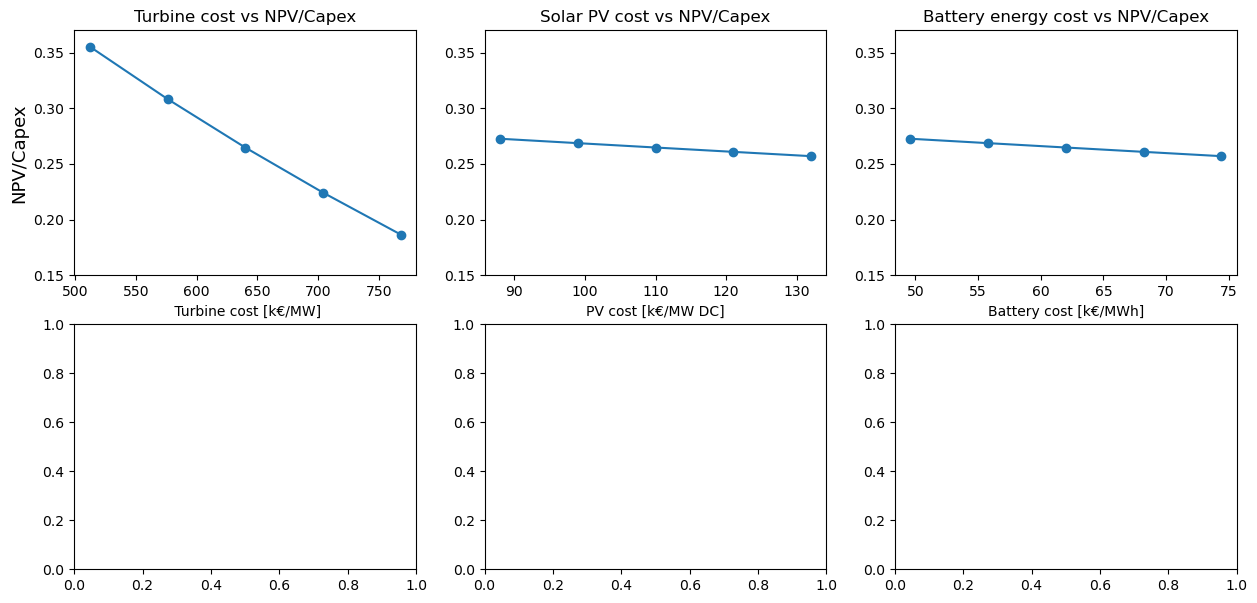

In [81]:
fig, ax = plt.subplots(2,3, figsize = (15,7))

# turbine-cost
ax[0,0].plot(turbine_costs/1000, NPV_capex, marker = "o")
ax[0,0].set_title("Turbine cost vs NPV/Capex")
ax[0,0].set_xlabel(" Turbine cost [k€/MW]")
ax[0,0].set_ylim(0.15, 0.37)
ax[0,0].set_ylabel("NPV/Capex", fontsize = 13)

# PV cost
ax[0,1].plot(PV_costs/1000, NPV_capex_PV, marker = "o")
ax[0,1].set_title("Solar PV cost vs NPV/Capex")
ax[0,1].set_xlabel("PV cost [k€/MW DC]")
ax[0,1].set_ylim(0.15, 0.37)

# Battery cost
ax[0,2].plot(battery_costs/1000, NPV_capex_battery, marker = "o")
ax[0,2].set_title("Battery energy cost vs NPV/Capex")
ax[0,2].set_xlabel("Battery cost [k€/MWh]")
ax[0,2].set_ylim(0.15, 0.37)


plt.show()